In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
from data_utils import *
from ml import *
from ml_models_pt import *
from ml_models_tf import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [ ]:
ob_data, trade_data, mp_data = load_ob_and_trade_data(
    folder = '../data/',
    contract = 'CAKEUSDT',
    start_date = datetime(2025, 4, 9),
    end_date = datetime(2025, 4, 9),
    td = timedelta(seconds=10),
    ob_format_func=ob_top_level_format,
    trade_format_func=trade_format)

2025-04-09


In [220]:
X_ob, X_trade, Y_data = build_data_set(
    ob_data,
    trade_data,
    mp_data,
    6,
    50,
    5
)

### Process Data

In [221]:
X_ob = signed_root_transform(X_ob)

In [222]:
train_split = int(len(X_ob) * 0.8)
x_ob_train, x_trade_train, y_train = X_ob[:train_split], X_trade[:train_split], Y_data[:train_split]
x_ob_val, x_trade_val, y_val = X_ob[train_split:], X_trade[train_split:], Y_data[train_split:]

In [223]:
x_ob_train, x_ob_val = normalise(x_ob_train, x_ob_val)
x_trade_train, x_trade_val = normalise(x_trade_train, x_trade_val)
y_train, y_val = normalise_std(y_train, y_val)

In [224]:
# remove outliers
keep = (y_train < 3.5) & (y_train > -3.5)
y_train = y_train[keep]
x_ob_train = x_ob_train[keep]
x_trade_train = x_trade_train[keep]

### Descriptive

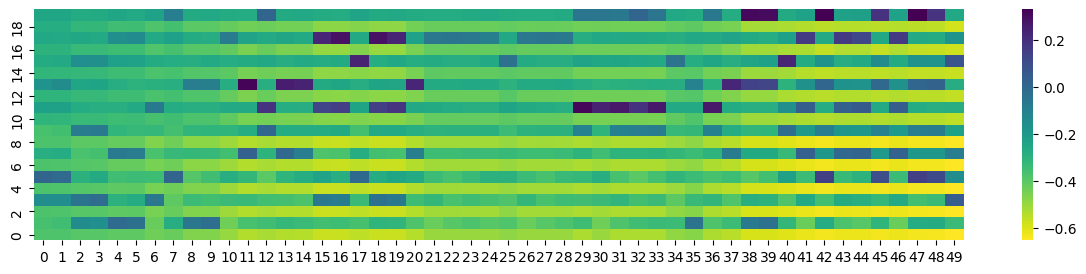

In [230]:
plt.figure(figsize=(15, 3))
sns.heatmap(x_ob_train[490].T, cmap='viridis_r')#, vmin=-5, vmax=100)
plt.gca().invert_yaxis()
plt.show()

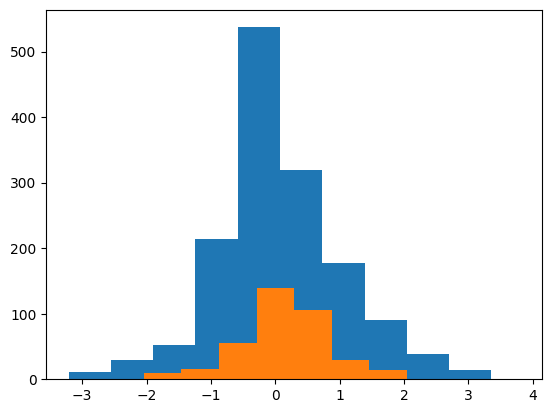

In [231]:
plt.hist(y_train)
plt.hist(y_val)
plt.show()

In [232]:
print(f"up-trends: {(y_val < 0).sum()/len(y_val)}")
print(f"down-trends: {(y_val > 0).sum()/len(y_val)}")

up-trends: 0.3699731903485255
down-trends: 0.4101876675603217


### Model Training

In [233]:
train_dataset = OrderBookDataset(x_ob_train, x_trade_train, y_train)
val_dataset = OrderBookDataset(x_ob_val, x_trade_val, y_val)

In [290]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [235]:
x_trade_train.shape

(1483, 50, 5)

In [291]:
model = OrderBookModel(
    input_size=50*20, 
    aux_size=50*5,
    hidden_size=128, 
    output_size=1, 
    dropout_rate=0.0
)

In [279]:
model = SimpleModel(
    input_size=50*20, 
    aux_size=50*5
)

In [292]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [293]:
# Train the model
trained_model, losses = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Output shape: torch.Size([64, 1, 1]), Target shape: torch.Size([64])


/opt/anaconda3/envs/trading/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 0.9236, Grad Norm: 0.3563
Epoch 2/10, Loss: 0.9210, Grad Norm: 0.3490
Epoch 3/10, Loss: 0.9745, Grad Norm: 0.3407
Epoch 4/10, Loss: 0.9363, Grad Norm: 0.4054
Epoch 5/10, Loss: 0.9438, Grad Norm: 0.4421
Epoch 6/10, Loss: 0.9004, Grad Norm: 0.3865
Epoch 7/10, Loss: 0.9399, Grad Norm: 0.2727
Epoch 8/10, Loss: 0.9273, Grad Norm: 0.3429
Epoch 9/10, Loss: 0.9483, Grad Norm: 0.3791
Epoch 10/10, Loss: 0.9309, Grad Norm: 0.4003


Processing 373 samples...

Confusion Matrix (% of Total Samples):
┌────────────┬─────────────────┬─────────────────┬─────────────┐
│            │ Predicted Down  │  Predicted Up   │    Total    │
├────────────┼─────────────────┼─────────────────┼───────── ───┤
│ Actual Down│       0.0%      │      47.4%      │    47.4%    │
├────────────┼─────────────────┼─────────────────┼─────────────┤
│ Actual Up  │       0.0%      │      52.6%      │    52.6%    │
├────────────┼─────────────────┼─────────────────┼─────────────┤
│ Total      │       0.0%      │     100.0%      │   100.0%    │
└────────────┴─────────────────┴─────────────────┴─────────────┘

Overall accuracy: 52.6%

Trend Prediction:
Correct trends: 153/291 (52.58%)
Up trend accuracy:   100.00%
Down trend accuracy: 0.00%


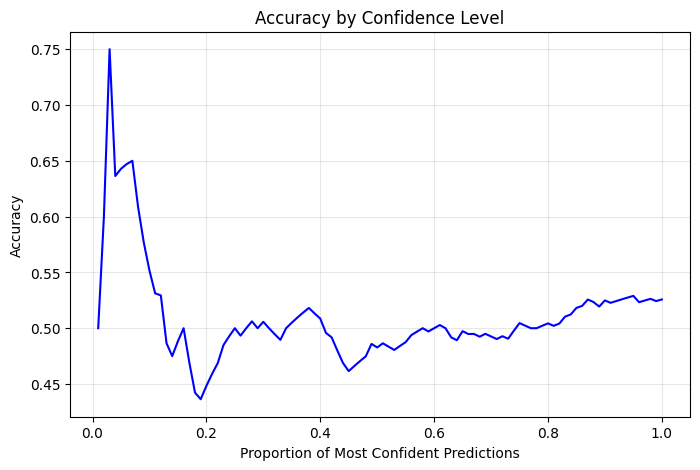

In [275]:
# Evaluate with val data
y_pred_val = evaluate_trend_prediction(trained_model, x_ob_val, x_trade_val, y_val)

Processing 6780 samples...

Confusion Matrix (% of Total Samples):
┌────────────┬─────────────────┬─────────────────┬─────────────┐
│            │ Predicted Down  │  Predicted Up   │    Total    │
├────────────┼─────────────────┼─────────────────┼───────── ───┤
│ Actual Down│       0.0%      │      50.7%      │    50.7%    │
├────────────┼─────────────────┼─────────────────┼─────────────┤
│ Actual Up  │       0.0%      │      49.3%      │    49.3%    │
├────────────┼─────────────────┼─────────────────┼─────────────┤
│ Total      │       0.0%      │     100.0%      │   100.0%    │
└────────────┴─────────────────┴─────────────────┴─────────────┘

Overall accuracy: 49.3%

Trend Prediction:
Correct trends: 2561/5196 (49.29%)
Up trend accuracy:   100.00%
Down trend accuracy: 0.00%


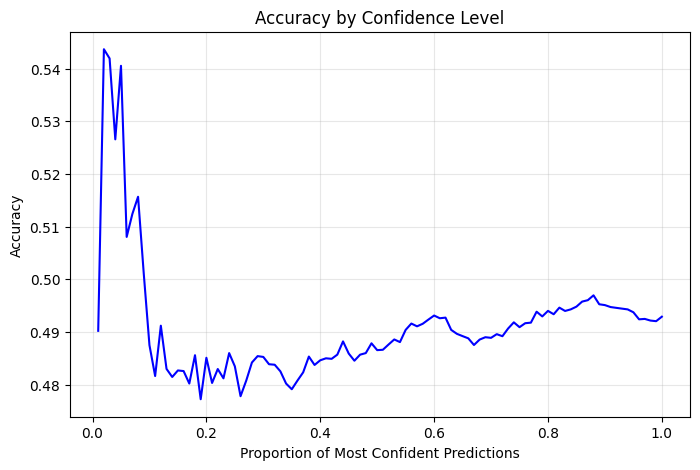

In [328]:
# Evaluate with your test data
y_pred_train = evaluate_trend_prediction(trained_model, x_train, x_train_aux, y_train)